# GridSearchCV - Lab

## Introduction

In this lab, we'll explore how to use scikit-learn's `GridSearchCV` class to exhaustively search through every combination hyperparameters until we find the values for a given model.

## Objectives

You will be able to:

* Understand and explain parameter tuning and why it is necessary 
* Design and create a parameter grid for use with sklearn's GridSearchCV module
* Use GridSearchCV to increase model performance through parameter tuning


## The Dataset

For this lab, we'll be working with the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning Dataset Repository.  We'll be using data about the various features of wine to predict the quality of the wine on a scale from 1-10 stars, making this a multiclass classification problem.  

### Getting Started

Before we can begin GridSearching our way to optimal hyperparameters, we'll need to go through the basic steps of modeling.  This means that we'll need to:

* Import and inspect the dataset (and clean, if necessary)
* Split the data into training and testing sets
* Build and fit a baseline model that we can compare against our GridSearch results.

Run the cell below to import everything we'll need for this lab.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
import time

Now that we've imported all the necessary libraries and frameworks for this lab, we'll need to get the dataset.  

Our data is stored in the file `winequality-red.csv`. Use pandas to import the data from this file and store it in a DataFrame.  Print the head to ensure that everything loaded correctly. 

In [2]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Great! Let's inspect our data a bit.  In the cell below, perform some basic Exploratory Data Analysis on our dataset.  Get a feel for your data by exploring the descriptive statistics and creating at least 1 visualization to help you better understand this dataset.

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


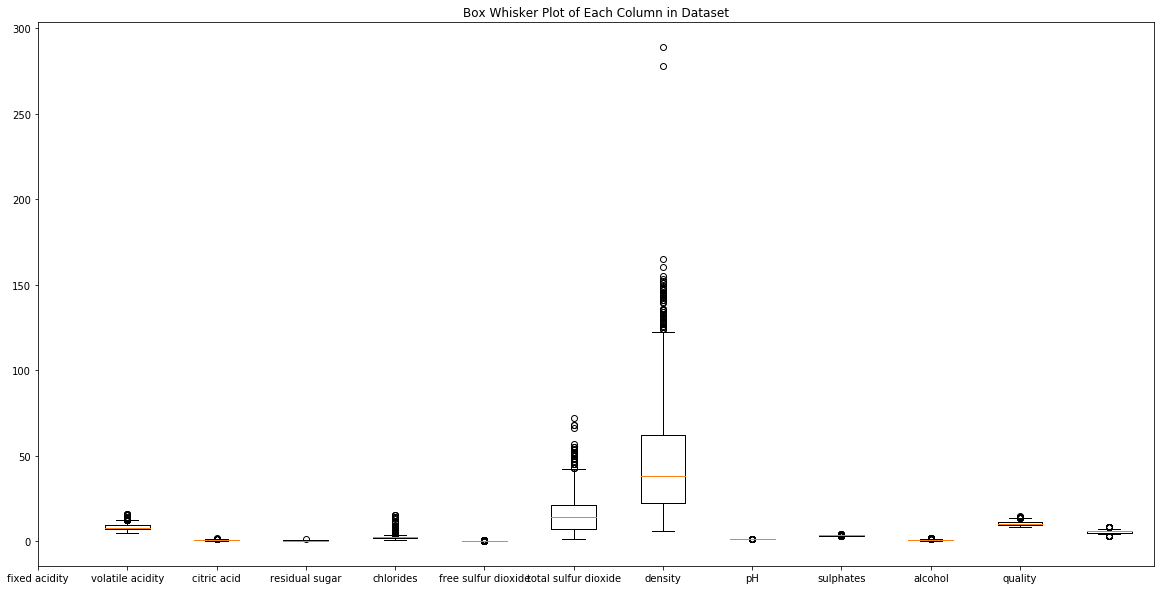

In [4]:
display(df.describe())

# Create a Box Whisker Plot of each column
plt.figure(figsize=(20, 10))
plt.boxplot([df[col] for col in df.columns])
plt.title("Box Whisker Plot of Each Column in Dataset")
plt.xticks(range(len(df.columns.values)), df.columns.values)
plt.show()

**_Question:_** Based on your findings during your Exploratory Data Analysis, do you think that we need to do any sort of preprocessing on this dataset? Why or why not?

Write your answer below this line:
________________________________________________________________________________________________________________________________


### Preprocessing our Data

Now, we'll perform any necessary preprocessing on our dataset before training our model.  We'll start by isolating the target variable that we are trying to predict.  

In the cell below:
* Store the data in the `quality` column inside the `y` variable
* Drop the `quality` column from the dataset

In [5]:
y = df['quality']
X = df.drop('quality', axis=1, inplace=False)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Training, Testing, and Cross Validation

First we want to do a train test split to create a holdout set to evaluatate how good our final model will be. Remember that any time we make modeling decisions based on a section of our data and we risk overfitting to that data. We can make use of **_Cross Validation_** when using `GridSearchCV` to do model selectionn and hyperparameter tuning then test our final model choice on the test set.

In the cell below:
* Create a training and testing set using train_test_split (set ```random_state=42``` for reproducability)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Creating a Baseline Model: Decision Trees

In the cell below:
* Create a `DecisionTreeClassifier` object.  
* Get the `cross_val_score` for this model, with the `cv` parameter set to `3`.
* Calculate and print the mean cross-validation score from our model.

**_Note:_** If you need a refresher on how to use `cross_val_score`, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [8]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 57.06%


## Grid Search: Decision Trees

Take a second to interpret the results of our cross-validation score.  How well did our model do? How does this compare to a naive baseline level of accuracy (random guessing)?

Write your answer below:

In [10]:
print("""
Our model did poorly overall, but still significantly better than we 
would expect from random guessing, which would have ~10% accuracy.
""")


Our model did poorly overall, but still significantly better than we 
would expect from random guessing, which would have ~10% accuracy.



### Creating A Parameter Grid

So far, our model has not have stellar performance. However, we've yet to modify the hyperparameters of the model.  Each dataset is different, and the chances that the best possible parameters for a given dataset also happen to be the default parameters set by by sklearn at instantiation is very low.  

This means that we need to try **_Hyperparameter Tuning_**.  There are several strategies for searching for optimal hyperparameters--the one we'll be using, **_Combinatoric Grid Searching_**, is probably the most popular, because it performs an exhaustive search of all possible combinations.  

The sklearn module we'll be using to accomplish this is `GridSearchCV`, which can be found inside of `sklearn.model_selection`.

Take a minute to look at sklearn's user guide for [GridSearchCV](http://scikit-learn.org/stable/modules/grid_search.html#grid-search), and then complete the following task.

In the cell below:

* Complete the `param_grid` dictionary.  In this dictionary, each key represents a parameter we want to tune, whereas the corresponding value is an array of every parameter value we'd like to check for that parameter.  For instance, if we would like try out the values `2`, `5`, and `10` for `min_samples_split`, our `param_grid` dictionary would include `"min_samples_split": [2, 5, 10]`.
* Normally, you would have to just try different values to search through for each parameter.  However, in order to limit the complexity of this lab, the parameters and values to search through have been provided for you.  You just need to turn them into key-value pairs inside of the `param_grid` dictionary. Complete `param_grid` so that it tests the following values for each corresponding parameter:
    * For `"criterion"`, try values of `"gini"` and `"entropy"`.
    * For `"max_depth"`, try `None`, as well as `2, 3, 4, 5` and `6`.
    * For `min_samples_split`, try `2, 5`, and `10`.
    * For `"min_samples_leaf"`, try `1, 2, 3, 4, 5` and `6`.
    
    
* Before you run the grid search take some time to understand what each of the specific hyperparameters mean. How does varying the values of each hyperparameter effect overfitting or underfitting of a decisionn tree model?

In [11]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

Now that we have our parameter grid set up, we can create and use our `GridSearchCV` object.  Before we do, let's briefly think about the particulars of this model. 

Grid Searching works by training a model on the data for each unique combination of parameters, and then returning the parameters of the model that performed best. In order to protect us from randomness, it is common to implement K-Fold Cross Validation during this step.  For this lab, we'll set K = 3, meaning that we'll actually train 3 different models for each unique combination of parameters.  

Given our `param_grid` and the knowledge that we're going to use Cross Validation with a value of 3, how many different Decision Trees will our `GridSearchCV` object have to train in order to try every possible combination and find the best parameter choices?

Calculate and print your answer in the cell below.

In [12]:
num_decision_trees = 3 * 2 * 6 * 3 * 6
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 648 different permutations.


That's a lot of Decision Trees! Decision Trees are generally pretty quick to train, but that isn't the case with every type of model we could want to tune.  Be aware that if you set a particularly large search space of parameters inside your parameter grid, then Grid Searching could potentially take a very long time. 

Let's create our `GridSearchCV` object and fit it.  In the cell below:
* Create a `GridSearchCV` object.  Pass in our model, the parameter grid, and `cv=3` to tell the object to use 3-Fold Cross Validation. Also pass in `return`
* Call our grid search object's `fit()` method and pass in our data and labels, just as if we were using regular cross validation.  

In [13]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                

### Examining the Best Parameters

Now that we have fit our model using Grid Search, we need to inspect it to discover the optimal combination of parameters.

In the cell below:

* Calculate the the mean training score.  An array of training score results can be found inside of the `.cv_results_` dictionary, with the key `mean_train_score`.
* Calculate the testing score using the our grid search model's `.score()` method by passing in our data and labels. 
* Examine the appropriate attribute to discover the best estimator parameters found during the grid search. 

**_HINT:_** If you're unsure what attribute this is stored in, take a look at sklearn's [GridSearchCV Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [14]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_train, y_train)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Testing Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 67.81%
Mean Testing Score: 61.80%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

**_Question:_** What effect, if any, did our parameter tuning have on model performance? Will GridSearchCV always discover a perfectly (global) optimal set of parameters? Why or why not?

In [15]:
print("""
The parameter tuning using GridSearchCV improved our model's performance 
by over 20%, from ~44% to ~66%. The model also shows no signs of 
overfitting, as evidenced by the close training and testing scores. 
Grid Search does not gaurantee that we will always find the globally 
optimal combination of parameter values, since it only exhaustively 
searches through the parameter values we provide, 
not every possible combination of every possible value for each parameter. 
This means that the model is only as good as the possible combinations of
the parameters we include in our parameter grid.
""")


The parameter tuning using GridSearchCV improved our model's performance 
by over 20%, from ~44% to ~66%. The model also shows no signs of 
overfitting, as evidenced by the close training and testing scores. 
Grid Search does not gaurantee that we will always find the globally 
optimal combination of parameter values, since it only exhaustively 
searches through the parameter values we provide, 
not every possible combination of every possible value for each parameter. 
This means that the model is only as good as the possible combinations of
the parameters we include in our parameter grid.



### Tuning More Advanced Models: Random Forests

Now that we have some experience with Grid Searching through parameter values for a Decision Tree Classifier, let's try our luck with a more advanced model and tune a _Random Forest Classifier_.  

We'll start by repeating the same process we did for our Decision Tree Classifier, except with a Random Forest Classifier instead. 

In the cell below:
* Create a `RandomForestClassifier` object.
* Use Cross Validation with `cv=3` to generate a baseline score for this model type, so that we have something to compare our tuned model performance to. 

In [16]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 61.89%


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Now that we have our baseline score, we'll create a parameter grid specific to our Random Forest Classifier.  

Again--in a real world situation, you will need to decide what parameters to tune, and be very thoughtful about what values to test for each parameter.  However, since this is a lab, we have provided the following table in the interest of simplicity.  Complete the `rf_param_grid` dictionary with the following key value pairs:
 
 
 |     Parameter     |         Values         |
|:-----------------:|:----------------------:|
|    n_estimators   |      [10, 30, 100]     |
|     criterion     |   ['gini', 'entropy']  |
|     max_depth     | [None, 2, 6, 10] |
| min_samples_split |       [5, 10]       |
|  min_samples_leaf |   [3, 6]   |

In [17]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

Great! Now that we have our parameter grid, we can grid search through it with our Random Forest. 

In the cell below, follow the process we used with Decision Trees above to grid search for the best parameters for our Random Forest Classifier.  

When creating your `GridSearchCV` object,  pass in:
* our Random Forest Classifier
* The parameter grid for our Random Forest Classifier
* `cv=3` 
* **_Do not_** pass in `return_train_score` as we did with our Decision Trees example above.  In the interest of runtime, we'll only worry about testing accuracy this time. 


**_NOTE:_** The runtime on the following cell will be over a minute on most computers.  

In [18]:
import time
start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on Random Forest Classifier: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Testing Accuracy: 64.55%
Total Runtime for Grid Search on Random Forest Classifier: 29.74 seconds

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


### Interpreting Our Results
Did tuning the hyperparameters of our Random Forest Classifier improve model performance? Is this performance increase significant? Which model did better? If you had to choose, which model would you put into production? Explain your answer.

In [19]:
print("""
Parameter tuning improved performance marginally, by about 6%. 
This is good, but still falls short of the top testing score of the 
Decision Tree Classifier by about 7%. Which model to ship to production 
would depend on several factors, such as the overall goal, and how 
noisy the dataset is. If the dataset is particularly noisy, 
the Random Forest model would likely be preferable, 
since the ensemble approach makes it more resistant to variance in the data. 
If the data is fairly stable from batch to batch and not too noisy, 
or if higher accuracy had a disproportionate effect on our business goals, 
then I would go with the Decision Tree Classifier because it scored higher.
""")


Parameter tuning improved performance marginally, by about 6%. 
This is good, but still falls short of the top testing score of the 
Decision Tree Classifier by about 7%. Which model to ship to production 
would depend on several factors, such as the overall goal, and how 
noisy the dataset is. If the dataset is particularly noisy, 
the Random Forest model would likely be preferable, 
since the ensemble approach makes it more resistant to variance in the data. 
If the data is fairly stable from batch to batch and not too noisy, 
or if higher accuracy had a disproportionate effect on our business goals, 
then I would go with the Decision Tree Classifier because it scored higher.



### Tuning Gradient Boosted Trees (AdaBoost)

The last model we'll tune in this lab is an AdaBoost Classifier, although tuning this model will generally be similar to tuning other forms of Gradient Boosted Tree (GBT) models.  

In the cell below, create an AdaBoost Classifier Object.  Then, as we did with the previous two examples, fit the model using using Cross Validation to get a baseline testing accuracy so we can see how an untuned AdaBoost model performs on this task.  

In [20]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for AdaBoost: {adaboost_mean_cv_score :.2%}")

Mean Cross Validation Score for AdaBoost: 54.22%


Great! Now, onto creating the parameter grid for AdaBoost.  

Complete the `adaboost_param_grid` dictionary by adding in the following key-value pairs:

|   Parameters  |      Values     |
|:-------------:|:---------------:|
|  n_estimators |  [50, 100, 250] |
| learning_rate | [1.0, 0.5, 0.1] |

In [21]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

Great.  Now, for the finale--use Grid Search to find optimal parameters for AdaBoost, and see how the model performs overall!

In [22]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {adaboost_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on AdaBoost: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Testing Accuracy: 56.30%
Total Runtime for Grid Search on AdaBoost: 120.33 seconds

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Evaluate the Best Performing Model on the Holdout Set

In [23]:
'''In this case the decision tree had the highest accuracy'''

holdout_accuracy = dt_grid_search.score(X_test, y_test)

print(f'The holdout accuracy for the final model is {holdout_accuracy :.2%}')

The holdout accuracy for the final model is 56.25%


## Summary

In this lab, we learned:

* How to iteratively search for optimal model parameters using `GridSearhCV`
* How to tune model parameters for Decision Trees, Random Forests, and AdaBoost models. 